# Content Generator

In [ ]:
# pip install langchain langchain_groq
# !pip install langgraph
# !pip install langchain langchain_groq langchain_community
# !pip install pyowm
# ! pip install langgraph-checkpoint-sqlite

In [1]:
groq_api_key="GROQ_API"

In [2]:
from langchain_groq import ChatGroq

In [3]:
model=ChatGroq(groq_api_key=groq_api_key,model_name="llama3-groq-70b-8192-tool-use-preview")

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [5]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [7]:
OUTLINE_CREATION_PROMPT="""You are an expert writer tasked with generating engaging, well-structured content on the topic provided by the user. Create a detailed outline along with content for each section of the essay.\
 Include relevant insights, examples, and explanations to provide depth to the subject.\
  The content should be clear, informative, and tailored to the target audience. \
  Ensure that each section flows logically into the next, with smooth transitions, and that the tone matches the intended purpose (e.g., informative, persuasive, or narrative)."""

In [9]:
COMPOSITION_ASSISTANT_PROMPT = """You are a content generation assistant tasked with writing high-quality, engaging content based on the user's request and any provided outlines or topics.\
 Generate the best possible content in a well-structured format, ensuring clarity, depth, and relevance.\
  If the user provides feedback or critiques, revise and improve your previous attempts to meet their expectations.\
  Utilize all available information to create content that is informative, coherent, and tailored to the target audience:


------

{content}"""

In [11]:
INTROSPECTIVE_ANALYSIS_PROMPT="""You are an expert reviewer tasked with evaluating a content submission. Provide constructive critique and detailed recommendations for improving the quality of the content.\
 Focus on areas such as length, depth, clarity, style, and structure.\
  Offer actionable suggestions to enhance the content's engagement, coherence, and overall effectiveness, ensuring it meets the intended purpose and audience expectations."""

In [13]:
RESEARCH_ACTION_PLAN_PROMPT="""You are a research assistant tasked with generating search queries to gather relevant information for writing the given content.\
 Create up to three highly effective search queries that will help find accurate and useful data for the topic at hand, ensuring the results provide valuable insights for the content creation process."""

In [15]:
RESEARCH_ANALYSIS_FEEDBACK_PROMPT= """You are a research assistant tasked with generating search queries to support requested revisions for the content outlined below.\
 Create up to three targeted search queries that will help gather relevant information to improve and refine the content based on the revision needs."""


In [16]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [17]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [18]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=OUTLINE_CREATION_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [19]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_ACTION_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [20]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=COMPOSITION_ASSISTANT_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [21]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=INTROSPECTIVE_ANALYSIS_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [22]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_ANALYSIS_FEEDBACK_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [32]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "Introspective Lens"

In [33]:
builder = StateGraph(AgentState)

In [34]:
builder.add_node("Strategic Visionary", plan_node)
builder.add_node("Creative Forge", generation_node)
builder.add_node("Introspective Lens", reflection_node)
builder.add_node("Exploration Blueprint", research_plan_node)
builder.add_node("Critical Insight Review", research_critique_node)

In [35]:
builder.set_entry_point("Strategic Visionary")

In [36]:
builder.add_conditional_edges(
    "Creative Forge", 
    should_continue, 
    {END: END, "Introspective Lens": "Introspective Lens"}
)


In [37]:
builder.add_edge("Strategic Visionary", "Exploration Blueprint")
builder.add_edge("Exploration Blueprint", "Creative Forge")

builder.add_edge("Introspective Lens", "Critical Insight Review")
builder.add_edge("Critical Insight Review", "Creative Forge")

In [38]:
graph = builder.compile(checkpointer=memory)

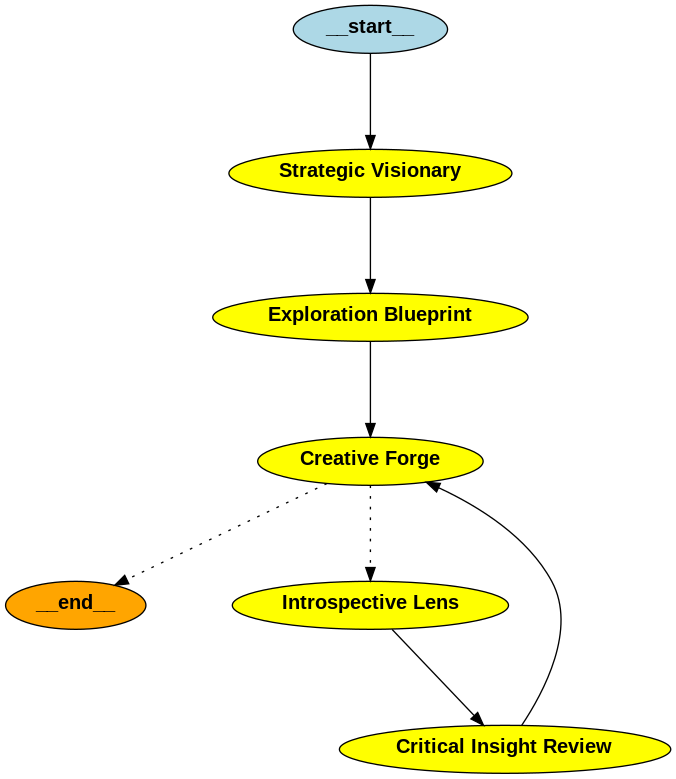

In [39]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [40]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "What is AI Agent?",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'Strategic Visionary': {'plan': 'I. Introduction\n\nAn AI agent is a computer program that acts on behalf of a user or other program to achieve a specific goal. It is designed to perceive its environment and take actions that maximize the probability of success. This essay will explore the concept of an AI agent, its types, and applications in various fields.\n\nII. Definition and Characteristics of an AI Agent\n\nAn AI agent is a software entity that can be viewed as perceiving its environment and acting upon it. The environment may be the physical world, a user, another program, or a simulated environment. An AI agent has several key characteristics:\n\n1. Autonomy: The ability to act independently without the direct intervention of humans or other systems.\n2. Perception: The ability to perceive its environment through sensors, such as cameras, microphones, or other devices.\n3. Reasoning: The ability to reason about the current state of the environment and decide what actions to t

{'Creative Forge': {'draft': 'An AI agent is a computer program that acts on behalf of a user or other program to achieve a specific goal. It is designed to perceive its environment and take actions that maximize the probability of success. An AI agent has several key characteristics, including autonomy, perception, reasoning, and action.\n\nThere are several types of AI agents, each with different capabilities and applications. These include simple reflex agents, model-based reflex agents, goal-based agents, utility-based agents, and learning agents. Each type of agent is suited for different tasks, such as controlling thermostats, autonomous vehicles, scheduling software, financial forecasting models, and recommendation systems.\n\nAI agents have numerous applications across various fields, including robotics, healthcare, finance, transportation, and customer service. They can assist in diagnosis, treatment planning, and patient care management in healthcare; analyze market trends, p

{'Creative Forge': {'draft': 'A. Introduction\n\nB. Definition and Characteristics of an AI Agent\n\nC. Types of AI Agents\n\nD. Applications of AI Agents\n\nE. Challenges and Limitations of AI Agents\n\nF. Conclusion', 'revision_number': 3}}
